In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from argparse import Namespace
import joblib as jl

from kpsn_test.routines.util import load_cfg, save_results, update, find_file

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

from kpsn.util import keypt_io
from kpsn_test import visualize as viz
from kpsn.models.pose import gmm


import numpy as np
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import linear_skeletal as ls
from kpsn.util import skeleton, alignment, logging, keypt_io
from kpsn_test import visualize as viz
import numpy as np
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import jax.tree_util as pt
import os

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:

experiment = 'lra_gt_scan'
plot_dir = f'/home/kaf200/datta/kai/mph/generative/plots/{experiment}/summaries'
results_out_dir = f'/home/kaf200/datta/kai/mph/generative/results/{experiment}/summaries'
results_dir = lambda run: f'/home/kaf200/datta/kai/mph/generative/results/{experiment}/{dset_name}_{run}'

In [32]:
dset_name = 'blscale'
hyp_name_short = 'pl'
other_param = 'wish-'

if dset_name == 'blscale':
    ref_sess = '3wk_m0'
    colorby = 'tgt_age'
elif dset_name == 'resamp':
    ref_sess = 'm0'
    colorby = 'bhv'

if hyp_name_short == 'ml':
    hyp_vals = [0, 1, 3, 6, 12]
    hyp_name = 'Morph d.o.f.'
    other_hyp = "Pose components = 3"
    runs = {val: f'{other_param}pl3-ml{val}' for val in hyp_vals}
elif hyp_name_short == 'pl':
    hyp_vals = [1, 3, 5, 10]
    hyp_name = 'Pose components'
    other_hyp = "Morph dof = 3"
    runs = {val: f'{other_param}pl{val}-ml3' for val in hyp_vals}

if other_param == '':
    other_param_disp = ""
elif other_param == "wish-":
    other_param_disp = " | Wishart"


In [33]:
load_obj = lambda filename, key: {
    val: jl.load(f'{results_dir(runs[val])}/{filename}.jl')[key]
    for val in hyp_vals}

fit_params = load_obj('fit', 'fit_params')
full_dataset = jl.load(f'{results_dir(runs[hyp_vals[0]])}/dataset.jl')
full_meta = full_dataset['metadata']

In [34]:
# construct corresponding dataset
feats, dataset, meta = viz.diagram_plots.matching_dataset(
    full_dataset['keypts'], full_dataset['metadata']['session_slice'], full_meta.get('frame_ids', None))

In [35]:
# calculate reconstructed poses for each fit model
reconst_feats = {val: viz.affine_mode.reconst_feat_with_params(
    feats[ref_sess], meta['session_ix'][ref_sess],
    fit_params[val].morph, len(feats))
    for val in hyp_vals}


In [36]:
reconst_errs = {
    val: viz.model_compare.keypt_errs(
        reconst_feats[val], dataset['keypts'], meta['session_slice'])
    for val in hyp_vals}

base_errs = viz.model_compare.keypt_errs(
    dataset['keypts'], feats[ref_sess], meta['session_slice'],
    single_b = True)

In [37]:
sess_order = list(meta['session_slice'].keys())
jl.dump(
    dict(
        keypt = skeleton.default_armature.keypt_names,
        hyp_val = hyp_vals,
        hyp = hyp_name_short,
        sess = sess_order,
        ref_sess = ref_sess,
        dataset = dset_name,
        mean_errs = np.array([[[
            reconst_errs[val][sess][i_kp]
            for i_kp in range(len(skeleton.default_armature.keypt_names))]
            for sess in sess_order]
            for val in hyp_vals])
    ),
    f'{results_out_dir}/{dset_name}-{other_param}{hyp_name_short}.jl'
)

['/home/kaf200/datta/kai/mph/generative/results/lra_gt_scan/summaries/blscale-wish-pl.jl']

/home/kaf200/datta/kai/mph/generative/plots/lra_gt_scan/summaries/blscale-wish-pl.png


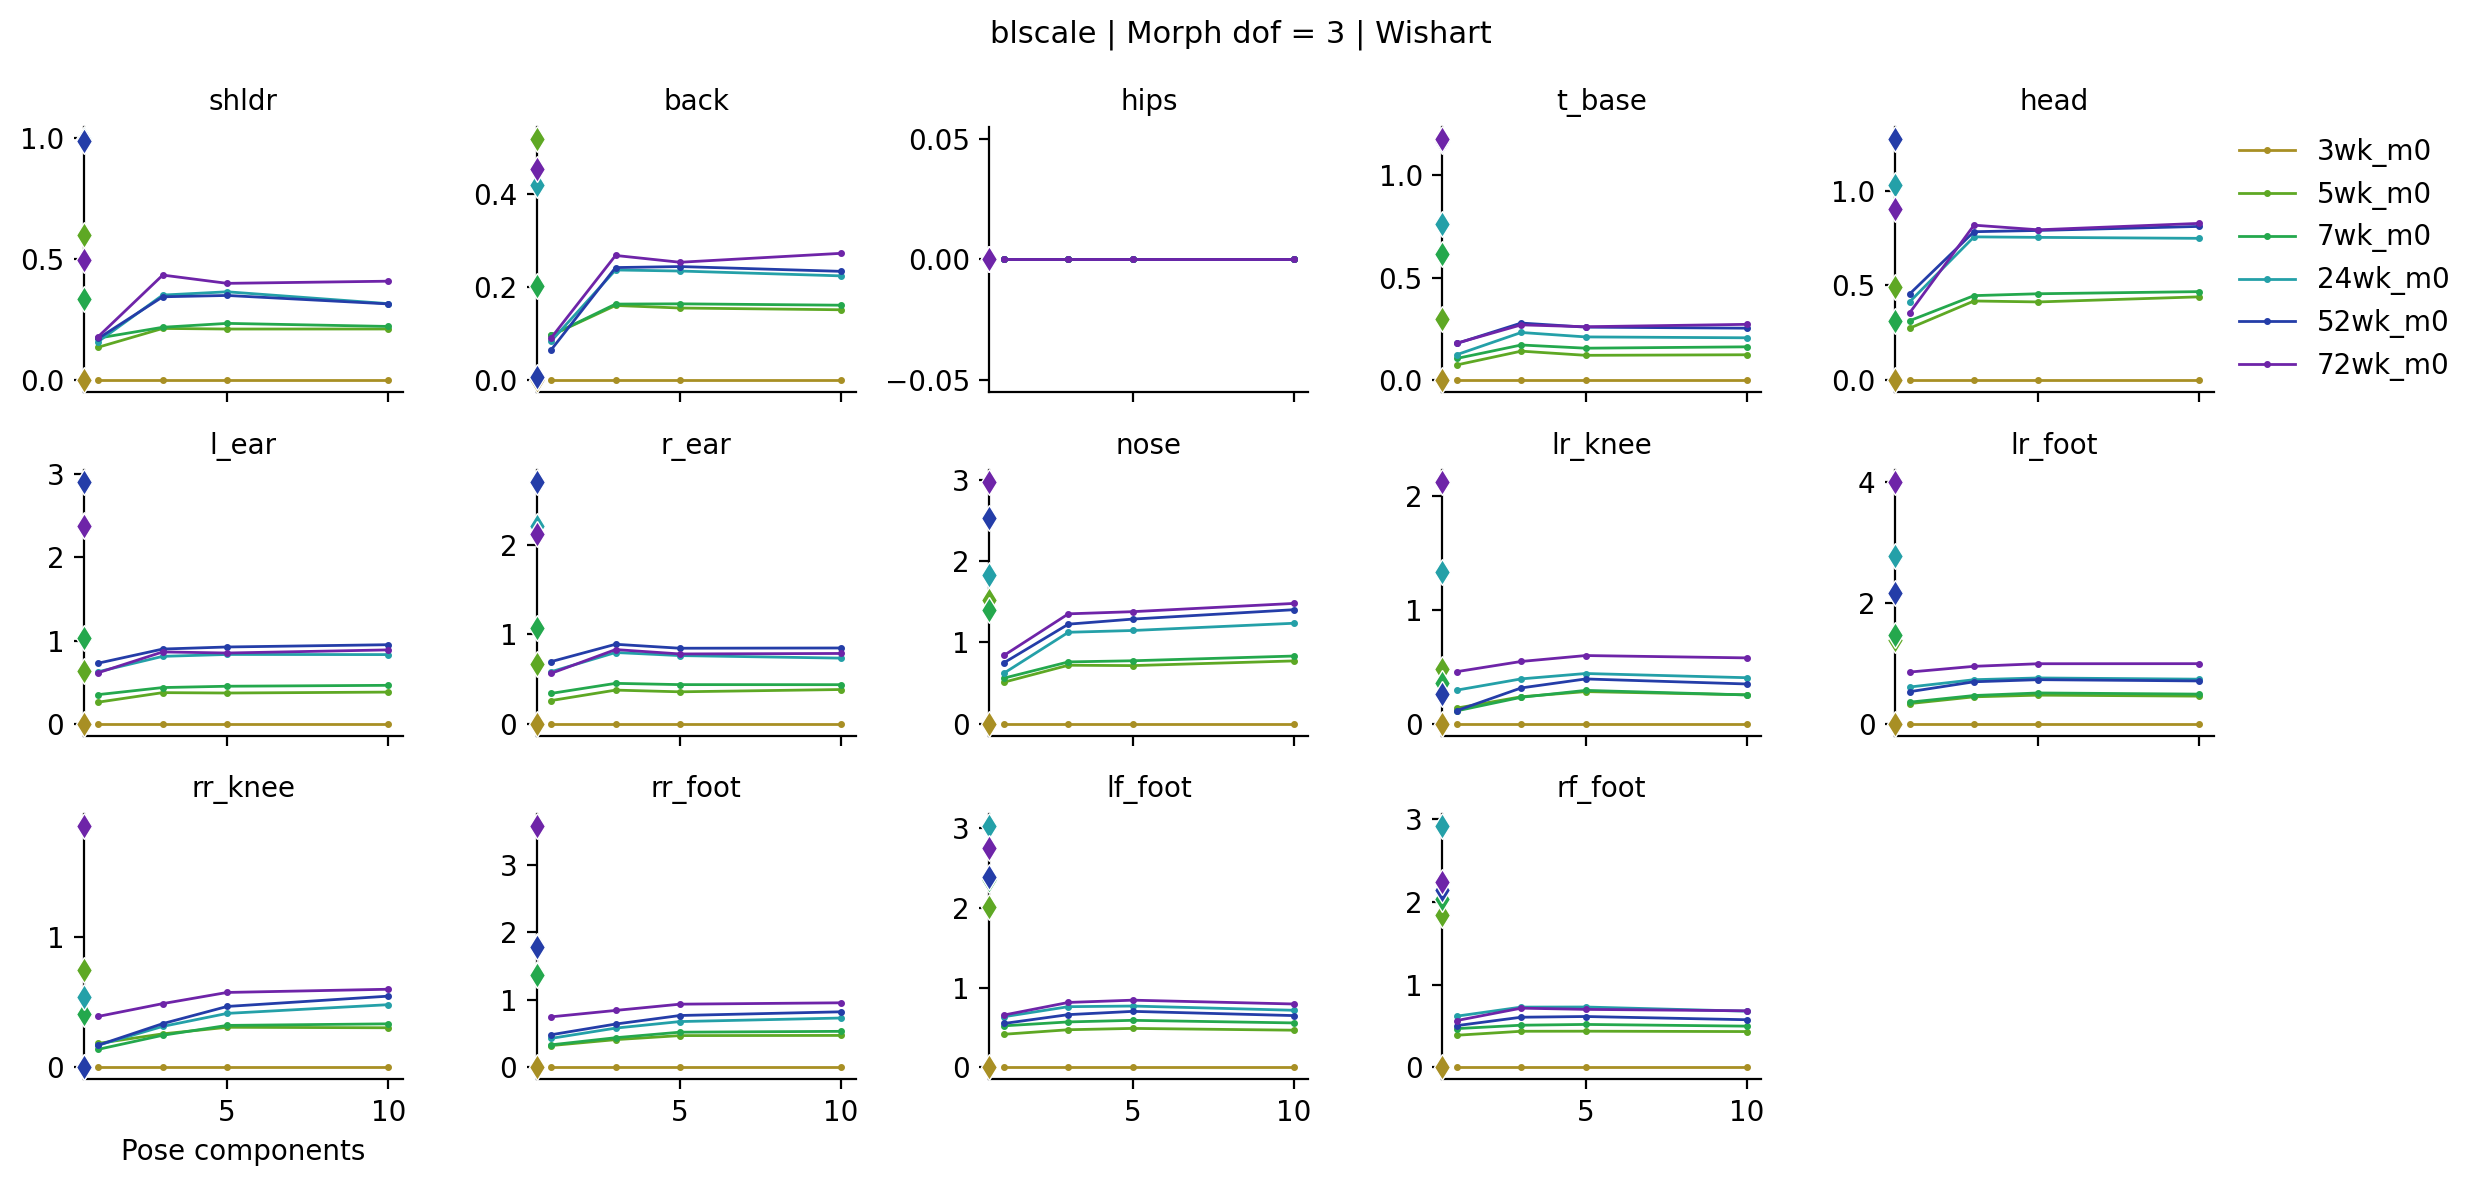

In [38]:
keypt_names = skeleton.default_armature.keypt_names
fig, axes, ax_grid = viz.struct.flat_grid(
    len(keypt_names), n_col = 5, ax_size = (2.5, 2),
    subplot_kw = dict(sharex = True, sharey = False),
    return_grid = True)
pal = viz.defaults.age_pal(full_meta[colorby])


for i_kp, (kp_name, ax) in enumerate(zip(keypt_names, axes)):
    for sess, slc in meta['session_slice'].items():
        ax.plot(hyp_vals, [reconst_errs[val][sess][i_kp] for val in hyp_vals], 
            '-o', ms = 1.5, lw = 1, color = pal[full_meta[colorby][sess]],
            label = sess)
    ax.set_title(kp_name, fontsize = 10)

# second pass once we have fixed xlim: base errs
for i_kp, ax in enumerate(axes):
    x0, x1 = ax.get_xlim()
    for sess in meta['session_slice']:
        sess_clr = pal[full_meta[colorby][sess]]
        ax.plot( # subj: base err
            [x0], [base_errs[sess][i_kp]],
            'd', ms = 6.5, mew = 0.5, mec = 'w', color = sess_clr,
            zorder = 10, clip_on = False
        )
    ax.set_xlim(x0, x1)

ax_grid[0, -1].legend(**viz.defaults.legend_kw)
ax_grid[-1, 0].set_xlabel(hyp_name)
fig.suptitle(f"{dset_name} | {other_hyp}{other_param_disp}", fontsize = 11)
sns.despine()
plt.tight_layout()

fname = f'{plot_dir}/{dset_name}-{other_param}{hyp_name_short}.png'
print(fname)
plt.savefig(fname, dpi = 300)


In [44]:
def add_avg(res):
    res['avg'] = res['mean_errs'][:, np.array(res['sess']) != res['ref_sess']].mean(axis = 1)
    return res

other_param = 'wish-'
blscale_ml = add_avg(jl.load(f'{results_out_dir}/blscale-{other_param}ml.jl'))
blscale_pl = add_avg(jl.load(f'{results_out_dir}/blscale-{other_param}pl.jl'))
resamp_ml  = add_avg(jl.load(f'{results_out_dir}/resamp-{other_param}ml.jl'))
resamp_pl  = add_avg(jl.load(f'{results_out_dir}/resamp-{other_param}pl.jl'))
all_results = [blscale_ml, resamp_ml, blscale_pl, resamp_pl]

/home/kaf200/datta/kai/mph/generative/plots/lra_gt_scan/summaries/wish-all.png


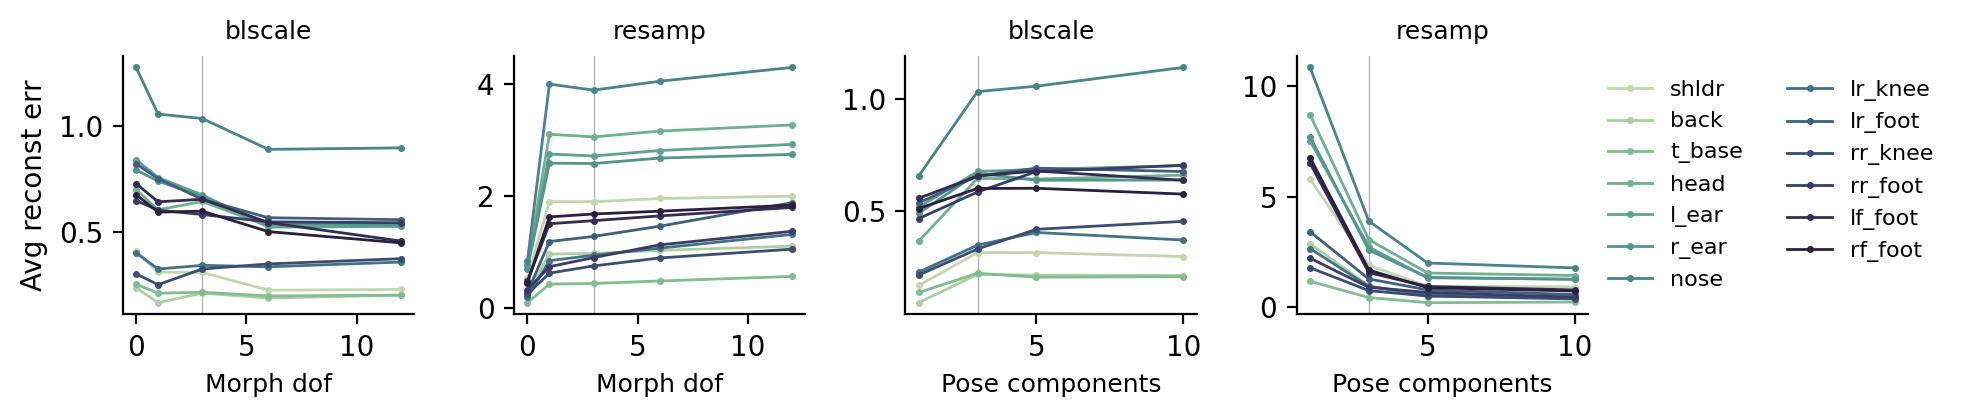

In [45]:

fig, axes, ax_grid = viz.struct.flat_grid(
    4, n_col = 4, ax_size = (2.5, 2.2),
    return_grid = True)
kp_pal = sns.color_palette("ch:start=.5,rot=-.75,light=.8", n_colors = len(blscale_ml['keypt']))

for i_kp, kp_name in enumerate(blscale_ml['keypt']):
    if kp_name == 'hips': continue
    for ax, res in zip(axes, all_results):
        ax.plot(res['hyp_val'], res['avg'][:, i_kp],
            '-o', ms = 1.5, lw = 1, color = kp_pal[i_kp],
            label = kp_name)

vline_kw = dict(zorder = -2, lw = 0.5, color = '.7')
for ax in axes[[0, 1]]:
    ax.axvline(3, **vline_kw)
    ax.set_title('blscale', fontsize = 9)
    ax.set_xlabel("Morph dof", fontsize = 9)
for ax in axes[[2, 3]]:
    ax.axvline(3, **vline_kw)
    ax.set_xlabel("Pose components", fontsize = 9)
for ax in axes[[0, 2]]: ax.set_title('blscale', fontsize = 9)
for ax in axes[[1, 3]]: ax.set_title('resamp', fontsize = 9)
    

ax_grid[0, -1].legend(ncols = 2, fontsize = 8, **viz.defaults.legend_kw)
ax_grid[0, 0].set_ylabel("Avg reconst err")
sns.despine()
plt.tight_layout()

fname = f'{plot_dir}/{other_param}all.png'
print(fname)
plt.savefig(fname, dpi = 300)